<a href="https://colab.research.google.com/github/ahmedazaz32/Offensive-language-identification-using-BERT/blob/main/Offensive_language_Identification_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install transformers

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import random
from google.colab import drive
from sklearn.model_selection import train_test_split

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

DRIVE_FOLDER = 'drive/MyDrive/NLP_Offensive_Language_Data/'
train = pd.read_csv(DRIVE_FOLDER + 'offenseval-training-v1.tsv', delimiter='\t',encoding='utf-8')
test = pd.read_csv(DRIVE_FOLDER + 'testset-taska.tsv', delimiter='\t',encoding='utf-8')

In [9]:
#We are only going to predict for task A
train = train.iloc[:, :3]

print("Loaded training data, shape: ", train.shape)
print(train.head().to_string())
print(" ")

print("Loaded test set A, shape: ", test.shape)
print(test.head().to_string())
print(" ")

#Check for null values
print(train.isnull().any())
print(test.isnull().any())

#Split into features and dependent variables
train_X = train["tweet"].values
test_X = test["tweet"].values
train_y = train.iloc[:, 2].values

Loaded training data, shape:  (13240, 3)
      id                                                                                                                                                                                   tweet subtask_a
0  86426                                                                                                                 @USER She should ask a few native Americans what their take on this is.       OFF
1  90194                                                                                                                     @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL       OFF
2  16820  Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT       NOT
3  62688                                                                                                                       @USER Someone should

Now we explore the distribution of sentence lengths so we can understand what max sentence length to set and therefore how much padding to do

<ipython-input-10-59a026253f6a>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sentence_lengths);


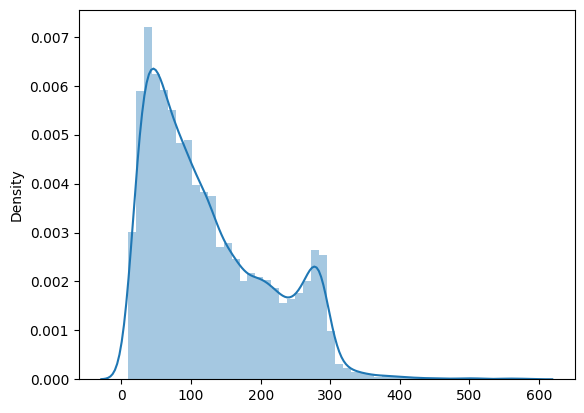

In [10]:
import seaborn as sns
sentence_lengths = [len(sentence) for sentence in train_X]
sns.distplot(sentence_lengths);
max_length = 320

In [ ]:
import tensorflow as tf
import tensorflow_datasets
!pip install transformers[sentencepiece]
from transformers import *

In [15]:
# Load dataset, tokenizer, model from pretrained model/vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# create list of input examples so we can get the data in the correct format for BERT
import json
import copy
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

input_examples = []

for ix, sentence in enumerate(train_X):
  #We replace the many instances of '@USER' in the tweets with a typical name e.g. 'Adam'
  #so that the pre-trained embedder can provide a more appropriate embedding for this word
  sentence = sentence.replace("@USER", "Adam")
  example = InputExample(guid=ix, text_a=sentence, label=train_y[ix])
  input_examples.append(example)

examples = glue_convert_examples_to_features(input_examples, tokenizer, max_length=max_length, label_list=list(set(train_y)), output_mode = "classification") # task='mrpc')

def gen():
    for ex in examples:
        yield  ({'input_ids': ex.input_ids,
                  'attention_mask': ex.attention_mask,
                  'token_type_ids': ex.token_type_ids},
                ex.label)

full_dataset = tf.data.Dataset.from_generator(gen,
    ({'input_ids': tf.int32,
      'attention_mask': tf.int32,
      'token_type_ids': tf.int32},
      tf.int64),
    ({'input_ids': tf.TensorShape([None]),
      'attention_mask': tf.TensorShape([None]),
      'token_type_ids': tf.TensorShape([None])},
      tf.TensorShape([])))

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/tokenizer.json


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

/usr/local/lib/python3.10/dist-packages/transformers/data/processors/glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be

In [18]:
#We create an F1 callback because the competition is judged on our F1 score
from keras.callbacks import Callback
from sklearn.metrics import f1_score

class F1Evaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        predictions = np.array([])
        truth = np.array([])
        for _ in range(28):
          x, y = next(iter(val_dataset))
          y_pred = self.model.predict(x).logits > 0
          y_pred = y_pred.argmax(axis=1)
          y = y.numpy()
          predictions = np.append(predictions, y_pred)
          truth = np.append(truth, y)
        score = f1_score(truth, predictions)
        print("\n F1-score - epoch: %d - score: %.6f \n" % (epoch+1, score))

#2. Modelling

Now we load a pre-trained BERT model with a classification layer appended to the end of the model and train it for 2 epochs

In [19]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased')
batch_size = 16
val_size = 1000

full_dataset = full_dataset.shuffle(len(train_X))
val_dataset = full_dataset.take(val_size).batch(batch_size)
train_dataset = full_dataset.skip(val_size).batch(batch_size)

train_steps_per_epoch = int((len(train_X) - val_size) / batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
f1 = F1Evaluation()

model.fit(train_dataset, epochs=2, steps_per_epoch=train_steps_per_epoch,
          validation_data=val_dataset, validation_steps=5,
          callbacks=[f1])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-cased/snapshots/5532cc56f74641d4bb33641f5c76a55d11f846e0/model.safetensors
Loaded 108,310,272 parameters in th

Epoch 1/2
1/1 [==============================] - 0s 446ms/step

 F1-score - epoch: 1 - score: 0.644351 

765/765 [==============================] - 1023s 1s/step - loss: 0.4767 - accuracy: 0.7788 - val_loss: 0.3462 - val_accuracy: 0.8750
Epoch 2/2


1/1 [==============================] - 0s 435ms/step

 F1-score - epoch: 2 - score: 0.608333 

765/765 [==============================] - 140s 183ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.3540 - val_accuracy: 0.8750
